# Kidney-Stone Prediction Project

Goal: Train and evaluate a supervised ML model to predict kidney stones from urine-test features, then generate predictions for new samples.\
Data: One labeled CSV for model development and one unlabeled CSV for final predictions.

Project outline:
1. (Optional) Ensuring reproducibility
2. Data loading & analysis
3. Splitting, preprocessing & baseline
4. Model selection
5. Model evaluation & insights
6. Final model: training & prediction


How to Run:

*   Install the required packages using requirements.txt (for quick in-text reference: NumPy, pandas, scikit-learn, and Matplotlib installed)
*   Place the two CSV files in the project root (or edit file path in part 2.1).
*   Run all cells top-to-bottom.

The notebook writes requirements_freeze.txt (exact versions, part 1.2) to ensure reproducibility and will save predictions.csv (part 6.3) as the output.

In [1]:
#imports

#part 1
import os, random
import numpy as np

import sys, platform, subprocess, json
import importlib

#part 2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

#part 3
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

#part 4
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#part 5
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#part 6
from sklearn.base import clone

## 1. Ensuring reproducibility

### 1.1 apply a seed to randomizers

In [2]:
SEED = 42 #:)
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)

# NOTE: For scikit-learn models, i need to set random_state=SEED when you instantiate them.

### 1.2 freeze package versions (optional)

In [3]:
#capture the environment versions
def ver(pkg):
    try:
        return importlib.import_module(pkg).__version__
    except Exception:
        return "not installed"

env_info = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy": ver("numpy"),
    "pandas": ver("pandas"),
    "scikit_learn": ver("sklearn"),
    "matplotlib": ver("matplotlib"),
}


# (Optional) save an exact environment snapshot for reproducibility
try:
    req = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True)
    with open("requirements_freeze.txt", "w", encoding="utf-8") as f:
        f.write(req)
except Exception as e:
    print("Skipping pip freeze:", e)

env_info

{'python': '3.12.12',
 'platform': 'Linux-6.6.105+-x86_64-with-glibc2.35',
 'numpy': '2.0.2',
 'pandas': '2.2.2',
 'scikit_learn': '1.6.1',
 'matplotlib': '3.10.0'}

## 2. Data loading & analysis


### 2.1 safe data loading

In [4]:

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# The paths (EDIT THESE to your actual file names/locations. this version works if the files are in the same directory)
LABELED_PATH = Path("urine_specimens.csv")
NEW_PATH = Path("new_urine_specimens.csv")

assert LABELED_PATH.exists(), f"Not found: {LABELED_PATH}. Edit LABELED_PATH."
assert NEW_PATH.exists(), f"Not found: {NEW_PATH}. Edit NEW_PATH."

df = pd.read_csv(LABELED_PATH, encoding="utf-8")
df_new = pd.read_csv(NEW_PATH, encoding="utf-8")

df.head(3)


,gravity,pH,osmolarity,conductivity,urea,calcium,kidney stones
0,1.022,6.21,442,20.6,398.0,4.18,1
1,1.020,5.86,567,25.3,214.0,3.34,0
2,1.011,5.53,455,10.9,170.0,1.16,0


### 2.2 data exploration

In [5]:
df.shape

(493, 7)

In [6]:
df_new.shape

(276, 6)

In [7]:
#inspect columns
df.columns

Index(['gravity', 'pH', 'osmolarity', 'conductivity', 'urea', 'calcium', 'kidney stones'], dtype='object')

In [8]:
#check for duplicates
df.duplicated().sum()

np.int64(0)

In [9]:
#take a peek
df.sample(5, random_state=SEED)

,gravity,pH,osmolarity,conductivity,urea,calcium,kidney stones
454,1.018,7.38,704,23.6,270.0,1.27,0
73,1.014,5.90,456,17.8,164.0,6.99,1
310,1.023,5.85,970,38.0,362.0,4.54,0
175,1.015,5.53,531,15.8,87.0,0.65,0
332,1.014,5.41,364,5.1,159.0,0.83,1


In [10]:
#set target + features
TARGET_COL = "kidney stones"

FEATURE_COLS = [c for c in df.columns if c not in set([TARGET_COL])]
(len(FEATURE_COLS), FEATURE_COLS[:10])  # count + preview

(6, ['gravity', 'pH', 'osmolarity', 'conductivity', 'urea', 'calcium'])

In [11]:
#missing values overview
(df.isna().sum().sort_values(ascending=False))

,0
pH,31
urea,17
gravity,0
osmolarity,0
conductivity,0
calcium,0
kidney stones,0


In [12]:
#numeric columns exploration (all cols are numeric)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols[:20], len(num_cols)

(['gravity',
  'pH',
  'osmolarity',
  'conductivity',
  'urea',
  'calcium',
  'kidney stones'],
 7)

In [13]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,493.0,1.017929,0.006761,1.005,1.012,1.018,1.022,1.04
pH,462.0,5.959242,0.653928,4.760,5.530,5.740,6.280,7.94
osmolarity,493.0,645.344828,235.320087,187.000,450.000,668.000,838.000,1236.00
conductivity,493.0,21.337931,7.579484,5.100,15.500,21.900,27.600,38.00
urea,476.0,276.771008,136.942724,10.000,164.000,272.000,385.000,620.00
calcium,493.0,4.118540,3.221149,0.170,1.450,3.160,6.630,14.34
kidney stones,493.0,0.442191,0.497151,0.000,0.000,0.000,1.000,1.00


In [14]:
#categorical columns exploration (none here, but still)

cat_cols = [c for c in df.columns if c not in num_cols]
cat_cols[:20], len(cat_cols)

([], 0)

In [15]:
#check class balance (mostly balanced)

(df[TARGET_COL].value_counts(normalize=True)*100).round(2).astype(str) + "%"

,proportion
kidney stones,
0,55.78%
1,44.22%


In [16]:
#correlation matrix

corr = df[num_cols].corr(numeric_only=True)
corr.round(2)

,gravity,pH,osmolarity,conductivity,urea,calcium,kidney stones
gravity,1.00,-0.29,0.72,0.49,0.66,0.50,0.31
pH,-0.29,1.00,-0.30,-0.16,-0.28,-0.21,-0.07
osmolarity,0.72,-0.30,1.00,0.73,0.82,0.48,0.24
conductivity,0.49,-0.16,0.73,1.00,0.50,0.33,0.15
urea,0.66,-0.28,0.82,0.50,1.00,0.50,0.27
calcium,0.50,-0.21,0.48,0.33,0.50,1.00,0.48
kidney stones,0.31,-0.07,0.24,0.15,0.27,0.48,1.00


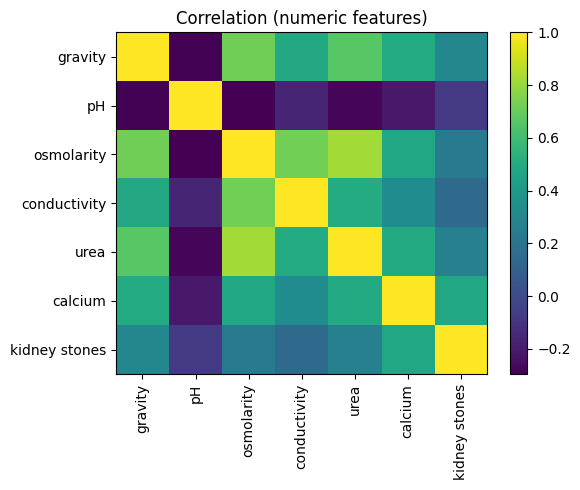

In [17]:
#heatmap of correlation matrix

plt.figure(figsize=(6,5))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Correlation (numeric features)")
plt.tight_layout()

conclusions from above (correlations):
1. gravity, osmolarity, conductivity are strongly collerated (we can drop some for logistic reg/svm or rely on regularization).
2. calcium has the strongest (positive) correlation with the target - kidney stones; pH has weakest correlation.
3. no higher correlation than 0.48 means a multivariate model is needed.

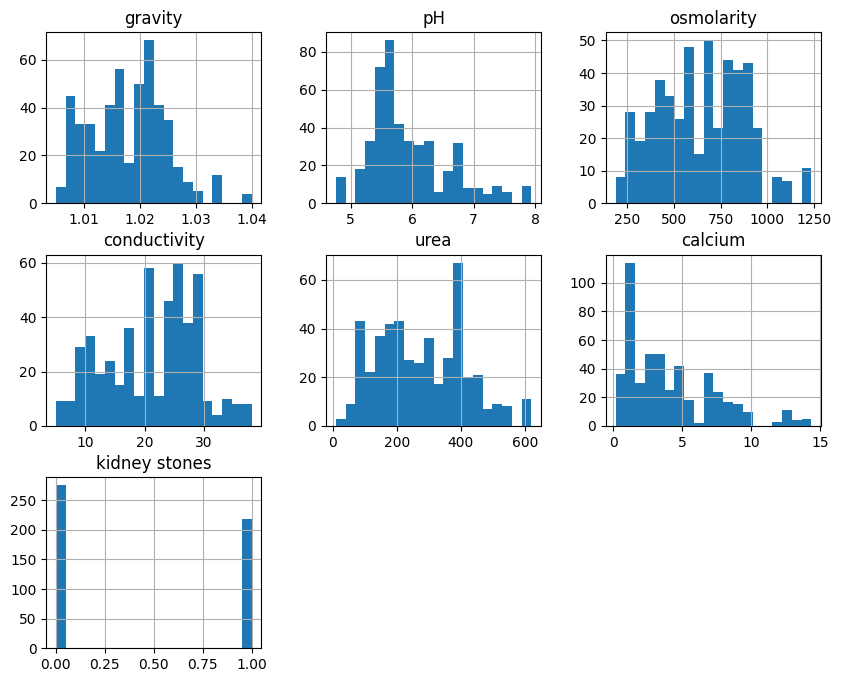

In [18]:
#distributions

_ = df[num_cols].hist(figsize=(10,8), bins=20)

conclusions from above (distributions):
1. Skewed variables are present(osmolarity, conductivity, urea, calcium). trees modelsdon’t care, but linear/SVM models benefit from scaling and sometimes log1p.

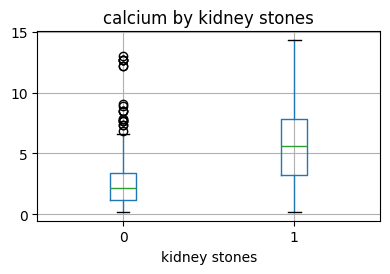

In [19]:
#feature vs target box plot (tried for 1 feature, will reuse if needed)
df.boxplot(column="calcium", by=TARGET_COL, figsize=(4,3))
plt.suptitle("")
plt.title("calcium by kidney stones")
plt.tight_layout()

## 3. Split, Preprocessing & Baseline


### 3.1 train/test split

In [20]:
X = df[FEATURE_COLS]
y = df[TARGET_COL]

#do a stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

X_train.shape, X_test.shape

#Stratification keeps the class ratio in both train and test roughly the same as the full dataset

((394, 6), (99, 6))

### 3.2 preprocessing pipeline

In [21]:

preproc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), #median imputation handles missing numeric values more robustly than mean
    ("scaler", StandardScaler()),
])

# fit ONLY on train
X_train_pp = preproc.fit_transform(X_train)

#transform test with train-fitted parameters
X_test_pp  = preproc.transform(X_test)

X_train_pp.shape, X_test_pp.shape

"""NOTE: If you later add cross-validation, keep preprocessing
inside the model pipeline so each fold learns imputation/scaling only from its training fold."""


'NOTE: If you later add cross-validation, keep preprocessing \ninside the model pipeline so each fold learns imputation/scaling only from its training fold.'

### 3.3 define baseline

In [22]:
# baseline gives us a floor, the real models should beat its F1/ROC-AUC

baseline = DummyClassifier(strategy="most_frequent", random_state=SEED) #predicts dominant class for everyone
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)

#metrics
metrics_base = {
    "accuracy": accuracy_score(y_test, y_pred_base),
    "precision": precision_score(y_test, y_pred_base, zero_division=0),
    "recall": recall_score(y_test, y_pred_base, zero_division=0),
    "f1": f1_score(y_test, y_pred_base, zero_division=0),
}

# we can add ROC-AUC if both classes exist in y_test
if len(np.unique(y_test)) == 2:
      y_prob_base = baseline.predict_proba(X_test)[:, 1]
      metrics_base["roc_auc"] = roc_auc_score(y_test, y_prob_base)

metrics_base

{'accuracy': 0.5555555555555556,
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'roc_auc': np.float64(0.5)}

## 4. Model Selection


### 4.1 select & train 3 candidate models

My choice of 3 candidate models:
1. Logistic Regression: standard linear baseline + interpretability.
2. Random Forest: reliable nonlinear baseline that’s strong on tabular, skewed, modest-size data.
3. SVM (RBF): complementary, more “margin-based” view. typically strong with a small, numeric feature set (once it is scaled).

NOTE: **Each model lives in a single scikit-learn Pipeline** so that the exact same object can be used for CV, GridSearch, final fit, and predictions (aim:reduce code shuffling later).

In [23]:
# Logistic Regression (interpretable linear baseline)

pipe_logreg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=SEED, max_iter=1000))
])

pipe_logreg
#strong baseline; coefficients give quick insight; works well with standardized features; fast.

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

In [24]:
# Random Forest (nonlinear, interaction-friendly)

pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),  # harmless for trees, keeps pipelines uniform
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=SEED, n_jobs=-1
    )),
])

pipe_rf
#handles nonlinearity/outliers well little prep; gives feature importances.

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [25]:
# SVM with RBF kernel (margin-based, good on medium data)

pipe_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=1.0, gamma="scale", random_state=SEED))
])

pipe_svm
#captures curved boundaries via RBF; benefits from scaling; often strong on tabular data with a handful of features.

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('clf', SVC(random_state=42))])

In [26]:
#candidates list

candidates = {
    "logreg": pipe_logreg,
    "rf": pipe_rf,
    "svm": pipe_svm,
}
list(candidates.keys())

['logreg', 'rf', 'svm']

### 4.2 Cross-validation & Hyperparameter Tuning

Notes:
*   Same CV across models for fair comparison.
*   Multiple metrics: F1 + ROC-AUC
*   refit="f1" -- best model per search is refit on the full training set using the F1-optimal parameters.

Reasoning for chosen metrics:
*   F1: thresholded metric balancing precision & recall --good when both FP and FN matter and there’s mild imbalance.
*   ROC-AUC: threshold-free ranking quality; it tells you if the model separates classes well even before you pick a threshold.

#### 4.2.1 CV and metrics configurations

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
"""Stratification leeps the positive/negative ratio similar in every fold.
that stabilizes the F1/ROC-AUC estimates when classes aren’t perfectly balanced."""

scoring = {"f1": "f1", "roc_auc": "roc_auc"}
(refit_metric := "f1"), cv

('f1', StratifiedKFold(n_splits=5, random_state=42, shuffle=True))

#### 4.2.2 parameter grids

In [28]:
param_grids = {
    "logreg": {
        "clf__C": [0.1, 1.0, 10.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],  # stable for l2
    },
    "rf": {
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [None, 6, 10],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
        "clf__max_features": ["sqrt", "log2"],
    },
    "svm": {
        "clf__C": [0.5, 1.0, 2.0, 4.0],
        "clf__gamma": ["scale", 0.1, 0.01],
        "clf__kernel": ["rbf"],  # keep fixed; we already chose RBF
    },
}
param_grids

{'logreg': {'clf__C': [0.1, 1.0, 10.0],
  'clf__penalty': ['l2'],
  'clf__solver': ['lbfgs']},
 'rf': {'clf__n_estimators': [200, 400],
  'clf__max_depth': [None, 6, 10],
  'clf__min_samples_split': [2, 5],
  'clf__min_samples_leaf': [1, 2],
  'clf__max_features': ['sqrt', 'log2']},
 'svm': {'clf__C': [0.5, 1.0, 2.0, 4.0],
  'clf__gamma': ['scale', 0.1, 0.01],
  'clf__kernel': ['rbf']}}

#### 4.2.3 grid search
(takes a few minutes)

In [29]:
search_results = []
best_models = {}

for name, pipe in candidates.items():
  grid = GridSearchCV(
          estimator=pipe,
          param_grid=param_grids[name],
          scoring=scoring,
          refit=refit_metric,
          cv=cv,
          n_jobs=-1, #uses all cores to keep runtimes reasonable.
          verbose=0,
          return_train_score=False, )

  grid.fit(X, y)  # NOTE: X,y are the full training set, CV handles the internal splits
  #no leakage because the pipeline (imputer+scaler+clf) is re-fit inside each fold only on that fold’s training split.

  best_models[name] = grid.best_estimator_

  #collect a compact row for this model
  row = {
      "model": name,
      "best_params": grid.best_params_,
      "cv_f1_mean": grid.cv_results_["mean_test_f1"][grid.best_index_],
      "cv_roc_mean": grid.cv_results_["mean_test_roc_auc"][grid.best_index_],
  }
  search_results.append(row)

results_df = pd.DataFrame(search_results).sort_values("cv_f1_mean", ascending=False).reset_index(drop=True)
results_df

,model,best_params,cv_f1_mean,cv_roc_mean
0,rf,"{'clf__max_depth': 10, 'clf__max_features': 's...",0.683994,0.809606
1,svm,"{'clf__C': 4.0, 'clf__gamma': 0.01, 'clf__kern...",0.674221,0.795437
2,logreg,"{'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__so...",0.665577,0.784063


In [30]:
best_models.keys(), best_models

(dict_keys(['logreg', 'rf', 'svm']),
 {'logreg': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler()),
                  ('clf', LogisticRegression(max_iter=1000, random_state=42))]),
  'rf': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler()),
                  ('clf',
                   RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                          n_estimators=200, n_jobs=-1,
                                          random_state=42))]),
  'svm': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler()),
                  ('clf', SVC(C=4.0, gamma=0.01, random_state=42))])})

### 4.3 model selection

Notes:
*   Use the CV summary to pick a winned (based on mean F1, with mean ROC-AUC as a tie-breaker)
*   Save the chosen pipeline for the next sections.
*   The chosen pipeline was already refit on the full training set inside GridSearchCV


In [31]:
# rank the CV results
ranked = results_df.sort_values(
    by=["cv_f1_mean", "cv_roc_mean"], ascending=False
).reset_index(drop=True)
ranked.head(3)


,model,best_params,cv_f1_mean,cv_roc_mean
0,rf,"{'clf__max_depth': 10, 'clf__max_features': 's...",0.683994,0.809606
1,svm,"{'clf__C': 4.0, 'clf__gamma': 0.01, 'clf__kern...",0.674221,0.795437
2,logreg,"{'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__so...",0.665577,0.784063


In [32]:
# search_results = []
# best_models = {}
# results_df = None
# #used for debugging, realized i had the append function outside the fofr loop.. so only the last model got appended...

In [33]:
# select the winner model

best_row = ranked.iloc[0]
winner_name = best_row["model"]
winner_params = best_row["best_params"]
winner = best_models[winner_name]

winner_name, winner_params

('rf',
 {'clf__max_depth': 10,
  'clf__max_features': 'sqrt',
  'clf__min_samples_leaf': 2,
  'clf__min_samples_split': 2,
  'clf__n_estimators': 200})

## 5. Model Evaluation & Insights

### 5.1 test set evaluation

In [34]:
# winner_name, winner already set in 4.3
y_pred = winner.predict(X_test)

# for ROC-AUC we need a score:
if hasattr(winner, "predict_proba"):
    y_score = winner.predict_proba(X_test)[:, 1]
else:
    y_score = winner.decision_function(X_test)

#evaluate on standard metrics
metrics_test = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_score),
}
metrics_test

{'accuracy': 0.9393939393939394,
 'precision': 0.9318181818181818,
 'recall': 0.9318181818181818,
 'f1': 0.9318181818181818,
 'roc_auc': np.float64(0.9921487603305785)}

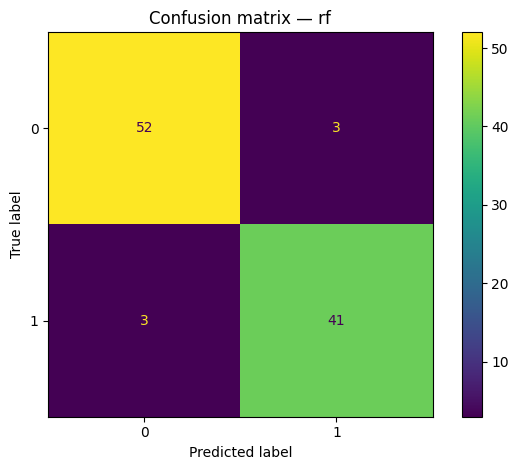

In [35]:
#confusion matrix

ConfusionMatrixDisplay.from_estimator(winner, X_test, y_test)
plt.title(f"Confusion matrix — {winner_name}")
plt.tight_layout()

### 5.2 feature importance evaluation

In [36]:
imp = pd.Series(winner.named_steps["clf"].feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)
imp

,0
calcium,0.386703
urea,0.131222
gravity,0.126024
pH,0.124191
conductivity,0.117871
osmolarity,0.113989


Insights:
1. Calcium is the biggest driver; the model's positive outputs will rely heavily on high Calcium
2. Concentration profile (gravity + osmolarity + conductivity making up 0.36) matters highly, but each one matters moderately
3. Urea & pH are still meaningful (a reason the rf won might be that pH's effects are nonlinear which it can handle)

## **6. Final Model: Training & Prediction**


### 6.1 refit the chosen model on the training split

In [37]:
final_model = clone(winner) # using tuned pipeline from 4.3
final_model.fit(X_train, y_train)

final_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [38]:
# Prepare the new data in the same feature order

X_new = df_new.reindex(columns=FEATURE_COLS) #ensure we only use the training-time features

X_new.shape, X_new.columns[:10]

((276, 6),
 Index(['gravity', 'pH', 'osmolarity', 'conductivity', 'urea', 'calcium'], dtype='object'))

### 6.2 Predict labels

In [39]:
y_new_pred = final_model.predict(X_new)

len(y_new_pred)


276

### 6.3 Save model output

In [40]:
preds_df = pd.DataFrame({
    "row_id": X_new.index,
    "kidney stones": y_new_pred,
})

preds_df.head()


,row_id,kidney stones
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


In [41]:
preds_df.to_csv("predictions.csv", index=False)